In [1]:
import pandas as pd 
import numpy as np
import gc
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, make_scorer
from tqdm import tqdm
from sklearn.model_selection import RandomizedSearchCV


In [2]:
data = pd.read_csv("/kaggle/input/predict-student-performance-from-game-play/train.csv",usecols=[0])


In [3]:
data = data['session_id'].groupby(data['session_id']).count()
PIECES = 10
CHUNK = int( np.ceil(len(data)/PIECES) )
reads = []
skips = [0]
for k in range(PIECES):
    a = k*CHUNK
    b = (k+1)*CHUNK
    if b>len(data): b=len(data)
    r = data.iloc[a:b].sum()
    reads.append(r)
    skips.append(skips[-1]+r)
print(f'To avoid memory error, we will read train in {PIECES} pieces of sizes:')
print(reads)

To avoid memory error, we will read train in 10 pieces of sizes:
[2684191, 2631991, 2638304, 2657670, 2644229, 2629801, 2596616, 2602258, 2619995, 2591891]


In [4]:
train = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', nrows=reads[0])
print('Train size of first piece:', train.shape )
train.head()

Train size of first piece: (2684191, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [5]:
labels = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( labels.shape )
labels.head()

(424116, 4)


,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


In [6]:
CATS = ['event_name', 'fqid', 'room_fqid', 'text_fqid', 'text', 'name']
NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y','hover_duration']
EVENTS = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']

In [7]:
def feature_engineer(train):
    
    dfs = []
########categorical###############
    for c in CATS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
###############nums###############
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id', 'level_group'])[c].agg(lambda x: x.max() - x.min())
        tmp.name = tmp.name + '_range'
        dfs.append(tmp)
    for c in NUMS: 
        tmp = train.groupby(['session_id', 'level_group'])[c].agg('median')
        tmp.name = tmp.name + '_median'
        dfs.append(tmp)

##############EVENTS list###################""    
    for c in EVENTS: 
        train[c] = (train.event_name == c).astype('int8') 
    for c in EVENTS + ['elapsed_time']: 
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum') 
        tmp.name = tmp.name + '_sum' 
        dfs.append(tmp) 
    for c in EVENTS :
        tmp = train.groupby(['session_id', 'level_group'])[c].agg(lambda x: x.mode().values[0])
        tmp.name = tmp.name + '_mode'
        dfs.append(tmp)
   

    
    train = train.drop(EVENTS,axis=1)
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [8]:
%%time

# PROCESS TRAIN DATA IN PIECES
all_pieces = []
print(f'Processing train as {PIECES} pieces to avoid memory error... ')
for k in range(PIECES):
    print(k,', ',end='')
    SKIPS = 0
    if k>0: SKIPS = range(1,skips[k]+1)
    train = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv',
                        nrows=reads[k], skiprows=SKIPS)
    df = feature_engineer(train)
    all_pieces.append(df)
    
# CONCATENATE ALL PIECES
print('\n')
del train; gc.collect()
df = pd.concat(all_pieces, axis=0)
print('Shape of all train data after feature engineering:', df.shape )
df.head()

Processing train as 10 pieces to avoid memory error... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 

Shape of all train data after feature engineering: (70686, 58)
CPU times: user 7min 45s, sys: 15.9 s, total: 8min 1s
Wall time: 9min 10s


,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,text_nunique,name_nunique,elapsed_time_mean,level_mean,page_mean,...,elapsed_time_sum,navigate_click_mode,person_click_mode,cutscene_click_mode,object_click_mode,map_hover_mode,notification_click_mode,map_click_mode,observation_click_mode,checkpoint_mode
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,30,7,17,56,3,8.579356e+04,1.945455,-1.0,...,14155937,0,0,0,0,0,0,0,0,0
20090312431273200,13-22,10,49,12,35,168,3,1.040601e+06,17.402381,-1.0,...,437052322,0,0,0,0,0,0,0,0,0
20090312431273200,5-12,10,39,11,24,124,3,3.572052e+05,8.054054,-1.0,...,105732736,0,0,0,0,0,0,0,0,0
20090312433251036,0-4,11,22,6,11,49,4,9.763342e+04,1.870504,0.0,...,13571045,0,0,0,0,0,0,0,0,0
20090312433251036,13-22,11,73,16,43,183,6,2.498852e+06,17.762529,5.1,...,3241011333,0,0,0,0,0,0,0,0,0


In [9]:
FEATURES = [c for c in df.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 57 features
We will train with 23562 users info


In [10]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}
# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25) 
    xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'learning_rate': 0.05,
    'max_depth': 4,
    'reg_alpha' : 0.5,
    'reg_lambda' : 0.5,
    'n_estimators': 1000,
    'early_stopping_rounds': 50,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.4
    }
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = labels.loc[labels.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = labels.loc[labels.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                verbose=0)
        print(f'{t}({clf.best_ntree_limit}), ',end='')
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

#########################
### Fold 1
#########################
1(209), 2(167), 3(278), 4(164), 5(140), 6(253), 7(89), 8(105), 9(107), 10(268), 11(121), 12(195), 13(169), 14(229), 15(199), 16(61), 17(53), 18(176), 
#########################
### Fold 2
#########################
1(207), 2(199), 3(159), 4(262), 5(92), 6(143), 7(113), 8(66), 9(156), 10(99), 11(239), 12(145), 13(107), 14(215), 15(149), 16(125), 17(99), 18(115), 
#########################
### Fold 3
#########################
1(497), 2(196), 3(160), 4(237), 5(151), 6(128), 7(200), 8(80), 9(190), 10(119), 11(89), 12(76), 13(114), 14(149), 15(237), 16(70), 17(106), 18(145), 
#########################
### Fold 4
#########################
1(421), 2(161), 3(142), 4(242), 5(128), 6(142), 7(106), 8(77), 9(114), 10(83), 11(139), 12(101), 13(183), 14(328), 15(232), 16(78), 17(79), 18(196), 
#########################
### Fold 5
#########################
1(323), 2(190), 3(265), 4(250), 5(136), 6(133), 7(155), 8(57), 9(118), 10(112), 11(8

In [11]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = labels.loc[labels.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [12]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

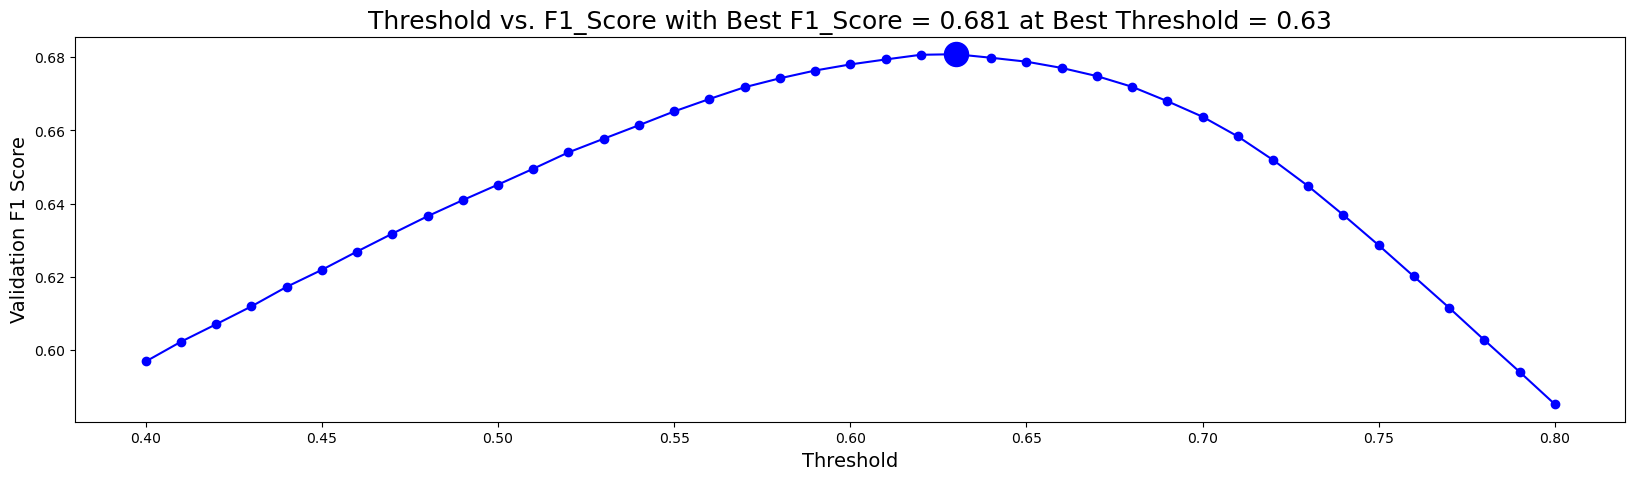

In [13]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [14]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.6295804034348917
Q1: F1 = 0.49464879356568364
Q2: F1 = 0.49020650262262344
Q3: F1 = 0.6223711254440477
Q4: F1 = 0.5806579449791467
Q5: F1 = 0.6102261440649372
Q6: F1 = 0.5863820702290558
Q7: F1 = 0.5421598140659027
Q8: F1 = 0.6022619882908903
Q9: F1 = 0.5199341557433221
Q10: F1 = 0.5935640062923944
Q11: F1 = 0.4976791537696062
Q12: F1 = 0.439045741196845
Q13: F1 = 0.6105475954971191
Q14: F1 = 0.5166378888246058
Q15: F1 = 0.46749129788008836
Q16: F1 = 0.5416868790132365
Q17: F1 = 0.4881344531968328
==> Overall F1 = 0.6808116255463644
